<font size="5"><b>Proposal for Group 42 - Heart Failure Fatality</b></font>

<b>Introduction </b>

Cardiovascular diseases, kill approximately 17 million people in the world, include heart attacks, heart strokes, and heart failure. Heart failure is caused when the heart cannot successfully send the required amount of blood to the body (Chicco, 2020). In this project, we will predict what factors determine whether patients can survive after heart failure. We will use dataset "https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv", which includes the data of 299 patients after heart failure at the Faisalabad Institute of Cardiology and at the Allied Hospital in Faisalabad; collected between April 2015 and December 2015. The dataset has several numerical and categorical variables with a final outcome of whether the patient died after having heart failure or not. 

The research question which we will try to answer in this project is: To what extent do ejection fraction and serum creatine levels affect the death possibility of a person if they suffer from heart failure? 


In [36]:
# Loading necessary packages
library(tidyverse)
library(tidymodels)
library(repr)

# Setting the seed to ensure reproducability 
set.seed(42) 

# Setting the number of maximum rows which will be displayed whenever a data tibble needs to be outputed 
options(repr.matrix.max.rows = 6)

<b>Preliminary exploratory data analysis </b>

In [42]:
#reads in data as well as turns relevant double columns into factors 

url<- "https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv"

# tranforms the data variables which need to factors into the factor datatype 
heart_data <- read_csv(url)%>%
    mutate(sex = as_factor(sex))%>%
    mutate(smoking = as_factor(smoking))%>%
    mutate(DEATH_EVENT = as_factor(DEATH_EVENT))%>%
    mutate(high_blood_pressure = as_factor(high_blood_pressure))%>%
    mutate(diabetes = as_factor(diabetes))%>%
    mutate(anaemia= as_factor(anaemia)) 


#creates factor levels for columns that make sense with column name, not just 0 and 1 
levels(heart_data$sex)<- c("female","male")
levels(heart_data$smoking)<- c("no","yes")
levels(heart_data$DEATH_EVENT)<- c("died","survived")
levels(heart_data$high_blood_pressure)<- c("no","yes")
levels(heart_data$diabetes)<- c("no","yes")
levels(heart_data$anaemia)<- c("no","yes")


#splits the data into training and testing data 
heart_data_split<- initial_split(heart_data, prop = .75, strata = DEATH_EVENT)
heart_train<- training(heart_data_split)
heart_test<- testing(heart_data_split)
 
heart_train

Parsed with column specification:
cols(
  age = col_double(),
  anaemia = col_double(),
  creatinine_phosphokinase = col_double(),
  diabetes = col_double(),
  ejection_fraction = col_double(),
  high_blood_pressure = col_double(),
  platelets = col_double(),
  serum_creatinine = col_double(),
  serum_sodium = col_double(),
  sex = col_double(),
  smoking = col_double(),
  time = col_double(),
  DEATH_EVENT = col_double()
)



age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>
75,no,582,no,20,yes,265000,1.9,130,male,no,4,survived
55,no,7861,no,38,no,263358,1.1,136,male,no,6,survived
65,no,146,no,20,no,162000,1.3,129,male,yes,7,survived
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,no,2060,yes,60,no,742000,0.8,138,female,no,278,died
45,no,2413,no,38,no,140000,1.4,140,male,yes,280,died
50,no,196,no,45,no,395000,1.6,136,male,yes,285,died


The split has been done in this proportion since it is viable for both training and testing pruporses since training a model requires more data points. This is one of the splits suggested in the course book as well (refer to the end of the notebook for reference). 

Next, we try to narrow down the variables which we will be using for our prediction. We primarily use forward propagation for this task.

In [38]:
# remove categorical columns from the dataset and only keep numerical to run forward propagation
heart_numerical <- heart_train %>% 
    select(-anaemia, -diabetes, -high_blood_pressure, -sex, -smoking, -time)

# CODE TO SELECT THE BEST PREDICTOR VARIABLES (code has been adapted from the course book. 
# (Citation is in references section)

#Evaluate which predictive variables to choose

# create object of names of all predictive variables
names <- colnames(heart_numerical %>% select(-DEATH_EVENT))

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>% 
     set_engine("kknn") %>% 
     set_mode("classification")

# create a 5-fold cross-validation object
heart_vfold <- vfold_cv(heart_numerical, v = 5, strata = DEATH_EVENT)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("DEATH_EVENT", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        heart_recipe <- recipe(as.formula(model_string), 
                                data = heart_numerical) %>% 
                          step_scale(all_predictors()) %>% 
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>% 
          add_recipe(heart_recipe) %>% 
          add_model(knn_spec) %>% 
          tune_grid(resamples = heart_vfold, grid = 10) %>% 
          collect_metrics() %>% 
          filter(.metric == "accuracy") %>% 
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}

accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,DEATH_EVENT ~ ejection_fraction,0.7190953
2,DEATH_EVENT ~ ejection_fraction+serum_creatinine,0.7950812
3,DEATH_EVENT ~ ejection_fraction+serum_creatinine+serum_sodium,0.7952789
4,DEATH_EVENT ~ ejection_fraction+serum_creatinine+serum_sodium+creatinine_phosphokinase,0.7778876
5,DEATH_EVENT ~ ejection_fraction+serum_creatinine+serum_sodium+creatinine_phosphokinase+age,0.7818357
6,DEATH_EVENT ~ ejection_fraction+serum_creatinine+serum_sodium+creatinine_phosphokinase+age+platelets,0.7511111


<b>NOTE</b>: The above code takes around 1.5 minutes to run as it uses forward propagation to see which predictor variables might be the most effective in predicting death event. Thus, the cell has been commented out so it doesn't get computed everytime the noterbook is run. We still use the results of that the code above provides for the rest of our report. We will uncomment when submitting the final version. 

A screenshot of the results has been pasted below for reference. 

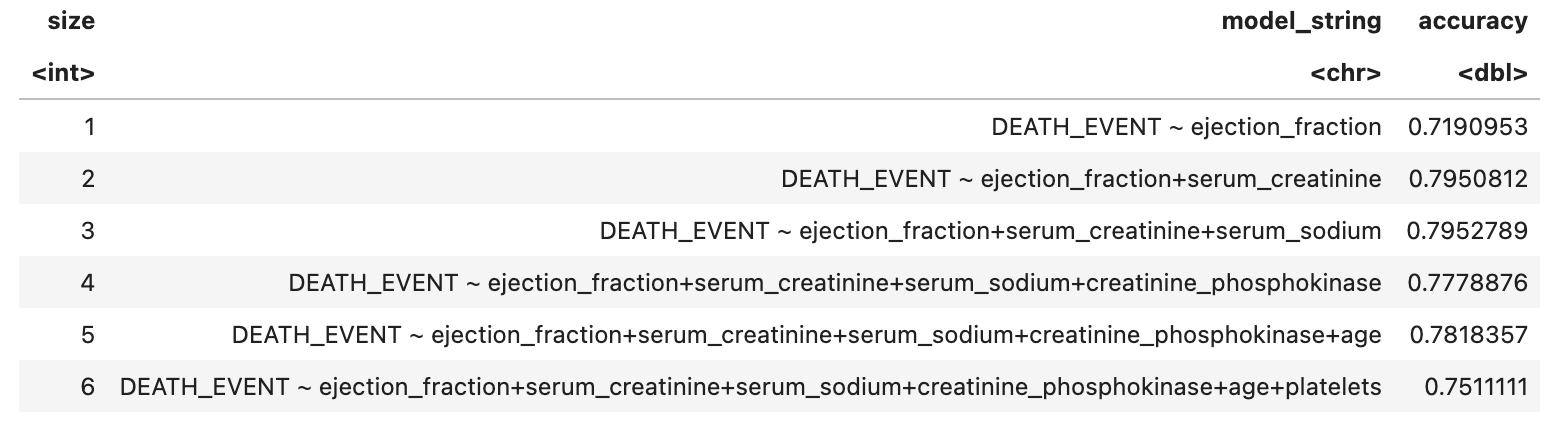

From this table we can easily infer that using ejection fraction and serum creatinine OR ejection fraction, serum creatinine and serum sodium offer the highest accuracy for predicting death event, that is close to 79.5%. However, biologically, ejection fraction and serum creatinine alone are the best predictors of death event (Chicco & Jurman, 2020). Therefore, we will be using these two variables as our predictors for death event in this classifier. 

Since it is way easier to use numerical variables for a classification model, we will be focusing on these for our analysis. However, just to infer the distribution of each catagorical variable, we write the code below: 

In [39]:
#Looking at the distribution of each categorical variable in the dataset 
num_obs <- nrow(heart_train)
anaemia_dist <- heart_train %>% 
  group_by(anaemia) %>% 
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )
diabetes_dist <- heart_train %>% 
  group_by(diabetes) %>% 
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )
bp_dist <- heart_train %>% 
  group_by(high_blood_pressure) %>% 
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )
death_dist <- heart_train %>% 
  group_by(DEATH_EVENT) %>% 
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )

anaemia_dist
diabetes_dist
bp_dist
death_dist

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



anaemia,count,percentage
<fct>,<int>,<dbl>
no,127,56.44444
yes,98,43.55556


diabetes,count,percentage
<fct>,<int>,<dbl>
no,135,60
yes,90,40


high_blood_pressure,count,percentage
<fct>,<int>,<dbl>
no,140,62.22222
yes,85,37.77778


DEATH_EVENT,count,percentage
<fct>,<int>,<dbl>
died,153,68
survived,72,32


Since range of their distrubutions is within ~10%, they all have approximately similar distributions. However, due to the medical significance, ease of implimentation and strength of corelation to the features, we still decide to only use ejection fractions and serum creatinine to predict "DEATH_EVENT". Therefore, all other variables can now be removed from the data table except ejection_fraction, serum_creatinine and DEATH_EVENT. 

In [40]:
# selecting appropriate columns from training set and testing set
heart_train <- heart_train %>% 
    select(ejection_fraction, serum_creatinine, DEATH_EVENT)

heart_test <- heart_test %>% 
    select(ejection_fraction, serum_creatinine, DEATH_EVENT)

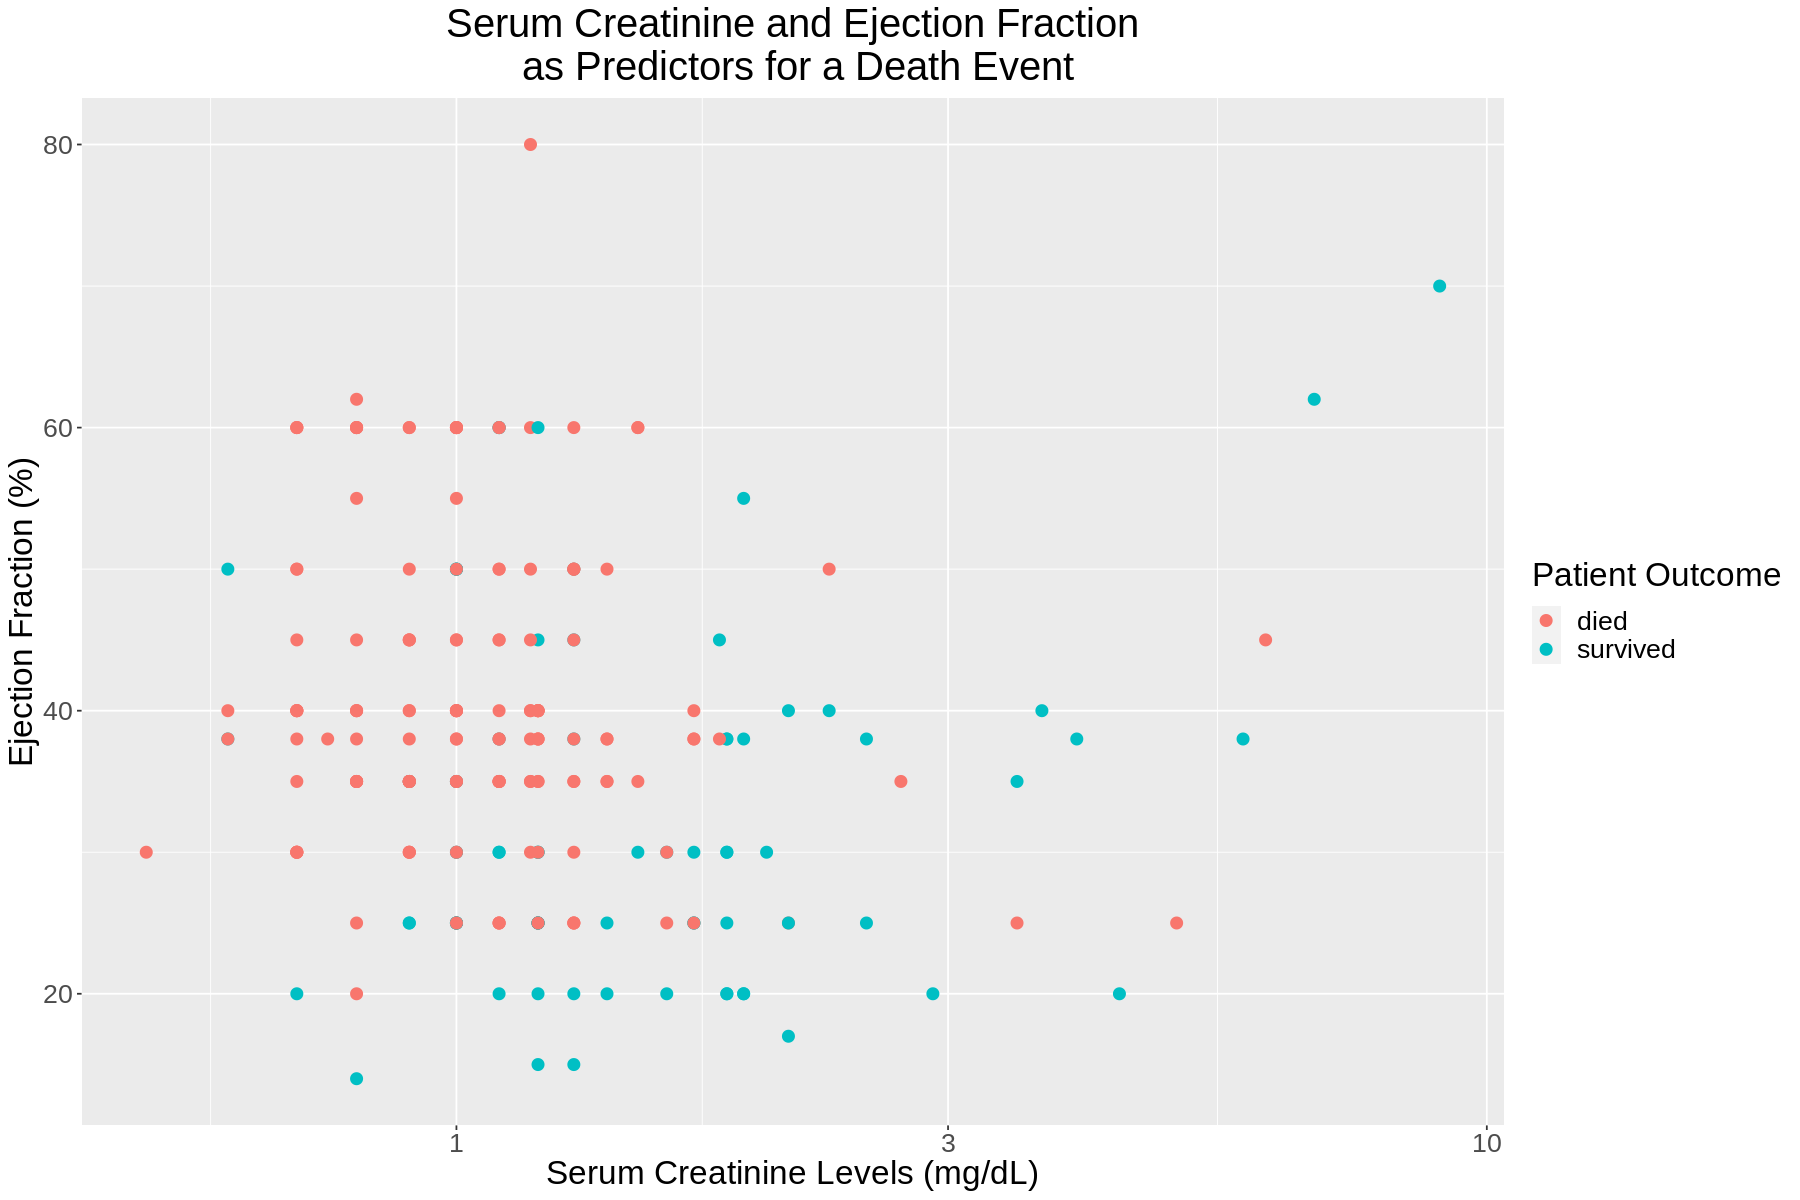

In [41]:
# plotting graph of serum creatinine vs ejection fraction to see their relation to DEATH_EVENT
options(repr.plot.height = 10, repr.plot.width = 15)

heart_plot<- heart_train%>%
    ggplot(aes(x= serum_creatinine, y = ejection_fraction))+
    geom_point(aes(color = DEATH_EVENT), size = 3)+
    labs(x = "Serum Creatinine Levels (mg/dL)", y = "Ejection Fraction (%)", 
         title = "Serum Creatinine and Ejection Fraction\n as Predictors for a Death Event",
         color = "Patient Outcome")+
    theme(text = element_text(size = 20), plot.title = element_text(hjust = .5))+
    scale_x_log10()

heart_plot

The plot above shows the distribution of our two predictors in relation to our variable that we are trying to predict, death event (in this graph it is labeled as patient outcome, but that is the same as death event). The x axis has been scaled to a logarithmic scale for better visualisation. We can easily notice that the major cluster of death outcomes are in the region where ejection fractions are between 25% - 60% and when logarithmic serum creatinine is between 0.3 - 2. Hence a clear decision boundary can be formulated which will be done in further analysis. 

<b>Methods</b>

We will perform a 5 v-fold (only 5 since 5 folds are enough to get a good approximate of the accuracy) classifier on our dataset and use the tune function to see which K value provides the highest accuracy for our predictor. In order to make this computationaly viable we will perform the tune on 20 K values ranging from 1 to 100 and keep the v-fold to just 5. We will use the variables Serum Creatinine and Ejection Fraction as our predictors of Death Event. We will also plot a decision boundary plot overlaid on our scatterplot of these 2 variables with our final predictor's decision boundary. This will help us visually see how well our classifier is performing

<b>Expected outcomes and significance</b>

We expect to find that serum creatine and ejection fraction can accurately predict if a patient who has already suffered heart failure is likely to survive in the following days. By taking these predictors and applying them to new patients who have suffered heart failure we can make accurate predictions about the patient's survival in the following days after their heart failure. This can help hospitals identify which patients will need special care and treatment in the following days after heart failure in order to increase the chance of survival. Future studies may want to recreate this study in other datasets as well as larger datasets in order to improve reliability. They may also want to look at these variables as predictors for other diseases and illnesses such as renal failure and high blood pressure.


<b>References</b>

1. UCI Machine Learning Repository: Heart Failure Clinical Records Data Set. (n.d.). Retrieved March 5, 2022, from https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records 

2. Tiffany Timbers, T. C. (2022, March 2). Data science. Chapter 6 Classification II: evaluation and tuning. Retrieved March 5, 2022, from https://datasciencebook.ca/classification2.html

3. Chicco, D., &amp; Jurman, G. (2020, February 3). Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone - BMC Medical Informatics and decision making. BioMed Central. Retrieved March 5, 2022, from https://doi.org/10.1186/s12911-020-1023-5